# Import needed modules

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image as image_preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [3]:
# Read data and use the image directory as the label for the images below it
def read(path):
    fp = []
    labels = []
    folds = os.listdir(path)

    for fold in folds:
        f_path = os.path.join(path, fold)
        imgs = os.listdir(f_path)
        for img in imgs:
            img_path = os.path.join(f_path, img)
            fp.append(img_path)
            labels.append(fold)
    f_index = pd.Series(fp, name='fp')
    label_index = pd.Series(labels, name='labels')
    return pd.concat([f_index, label_index], axis=1)

path = './Multi-class Weather Dataset'
df = read(path)

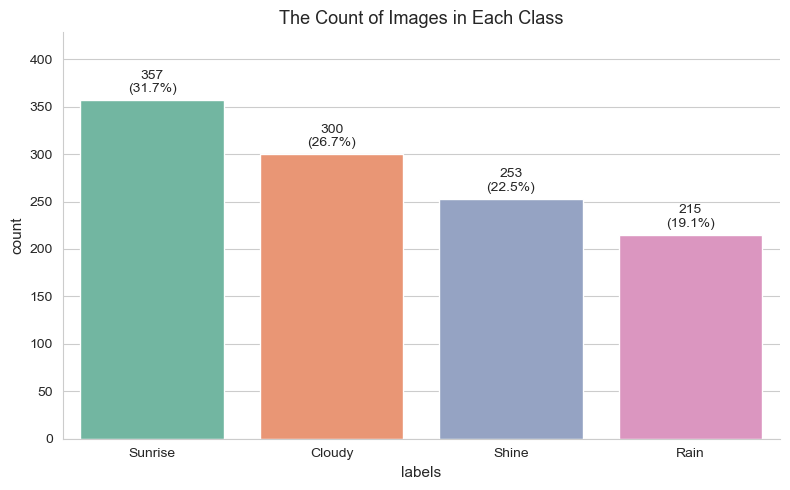

In [5]:
# plot the data distribution in each class
def plot_distribution(df):
    label_num = df['labels'].value_counts()
    label_percent = label_num / len(df) * 100
    sns.set_style("whitegrid")
    p = sns.color_palette("Set2")
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = sns.barplot(
        x=label_num.index,
        y=label_num.values,
        palette=p,
        ax=ax
    )
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        pct = label_percent[i]
        label = f'{int(height)}\n({pct:.1f}%)'
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, label,
                ha='center', va='bottom', fontsize=10)

    ax.set_title(f'The Count of Images in Each Class', fontsize=13)
    ax.set_xlabel('labels', fontsize=11)
    ax.set_ylabel('count', fontsize=11)
    ax.set_ylim(0, max(label_num.values) * 1.2)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

plot_distribution(df)

### **Split dataframe into train, valid, and test**

In [8]:
train_set, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

valid_set, test_set = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

### **Create image data generator**

In [11]:
# create image data generator with image augmentation
def generator(train=True):
    if train:
        return ImageDataGenerator(
            rescale=1. / 255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        return ImageDataGenerator(
            rescale=1./255,
        )

In [13]:
b_s = 32
img_size = (150, 150)
channels = 3
shape = (img_size[0], img_size[1], channels)
train_gen1 = generator(train=True)
test_datagen = generator(train=False)

# training generator
train_gen = train_gen1.flow_from_dataframe(
    dataframe=train_set,
    x_col='fp',
    y_col='labels',
    target_size=img_size,
    batch_size=b_s,
    class_mode='categorical',
    shuffle=True
)

# validation generator
valid_gen = test_datagen.flow_from_dataframe(
    dataframe=valid_set,
    x_col='fp',
    y_col='labels',
    target_size=img_size,
    batch_size=b_s,
    class_mode='categorical',
    shuffle=True
)

# testing generator
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col='fp',
    y_col='labels',
    target_size=img_size,
    batch_size=b_s,
    class_mode='categorical',
    shuffle=False
)
print(shape)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
(150, 150, 3)


### **Ploting Processed Images**

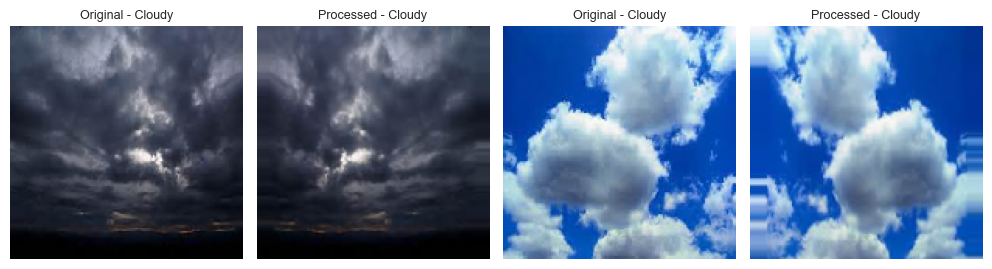

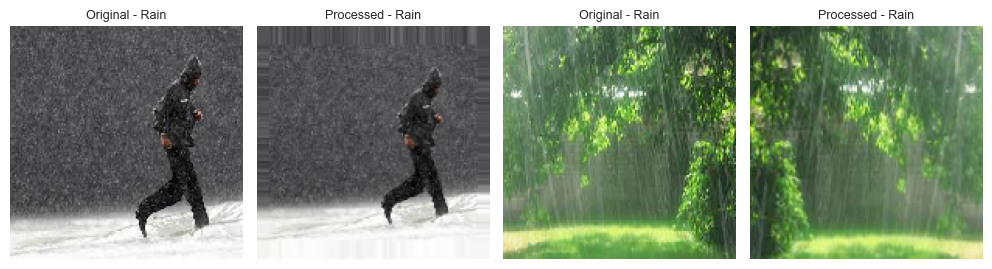

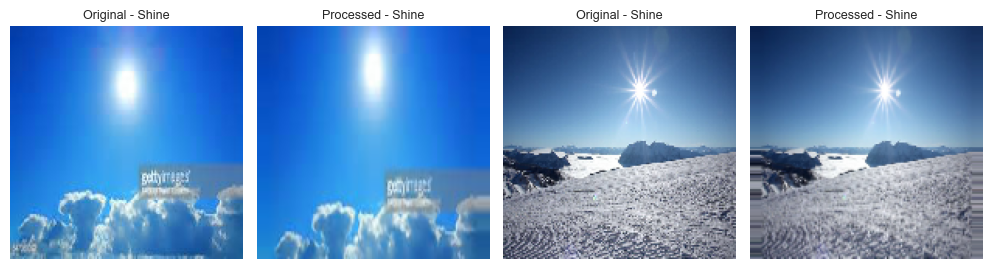

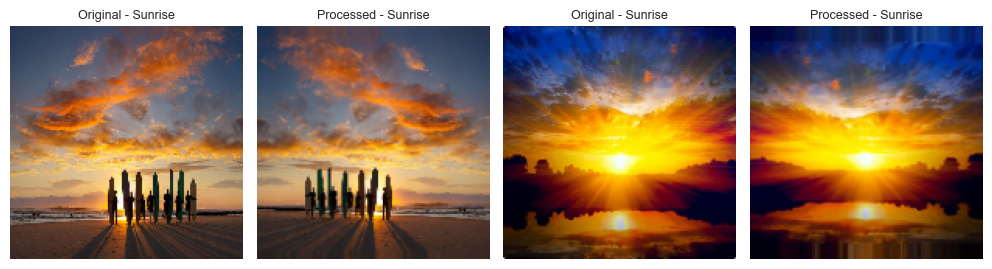

In [16]:
import matplotlib.pyplot as plt
import random
classes = df['labels'].unique()
gen = generator(train=True)
for cls in classes:
    sample_rows = df[df['labels'] == cls].sample(n=2, random_state=42).reset_index(drop=True)
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))  # 1 row, 4 images
    for i in range(2):
        img_path = sample_rows.loc[i, 'fp']
        img = image_preprocessing.load_img(img_path, target_size=img_size)
        x = image_preprocessing.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        axes[2 * i].imshow(img)
        axes[2 * i].set_title(f"Original - {cls}", fontsize=9)
        axes[2 * i].axis('off')

        # Augmented image
        aug_iter = gen.flow(x, batch_size=1, shuffle=False)
        aug_img = next(aug_iter)[0]
        axes[2 * i + 1].imshow(aug_img)
        axes[2 * i + 1].set_title(f"Processed - {cls}", fontsize=9)
        axes[2 * i + 1].axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

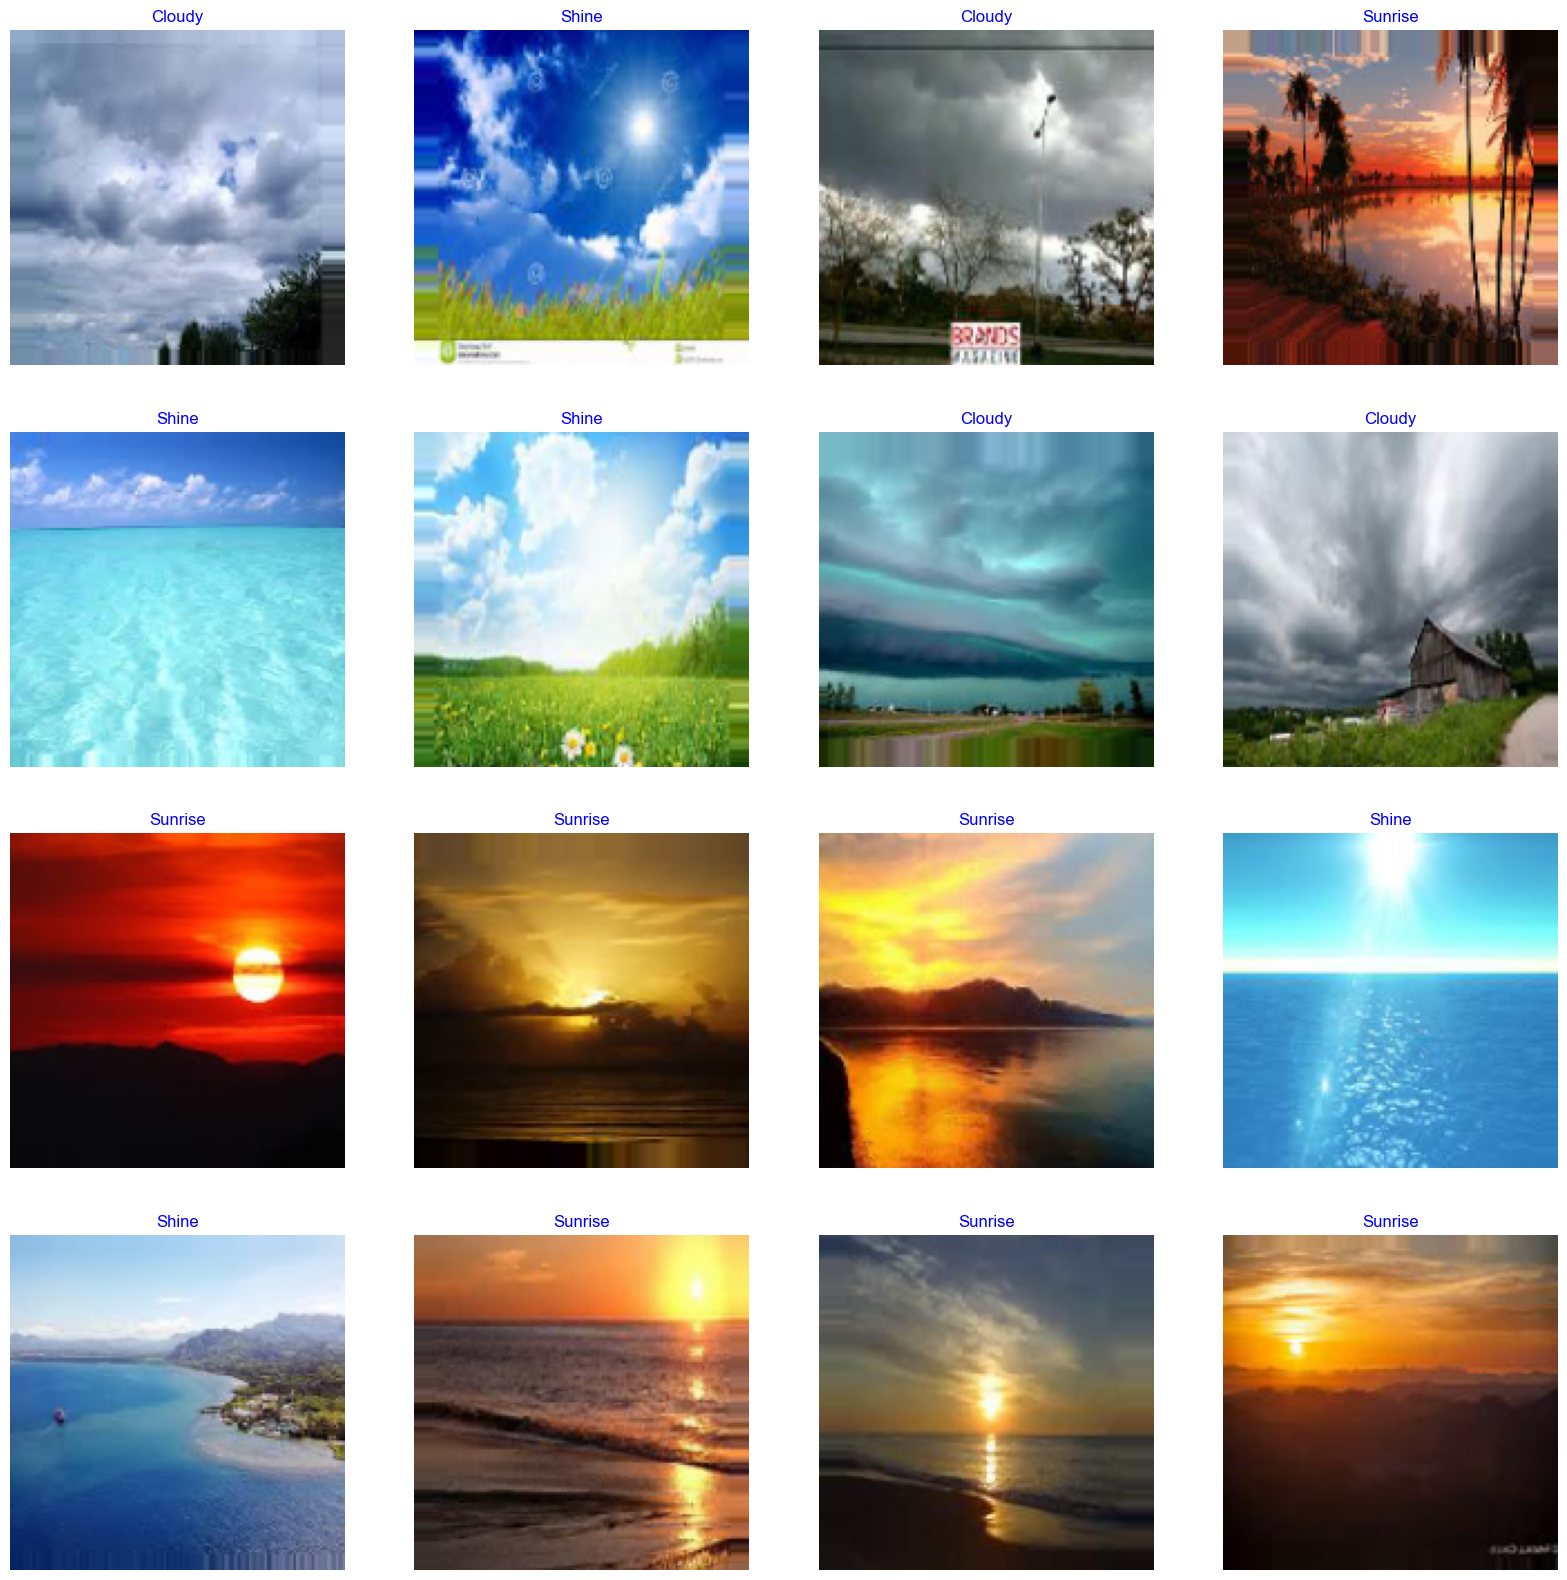

In [18]:
# Show processed image sample
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(iter(train_gen))
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers

m = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=shape
)

model = Sequential([
    m,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    
    Dense(512, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),

    Dense(256, kernel_regularizer=regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,051,116 (84.12 MB)

 Trainable params: 21,992,492 (83.89 MB)

 Non-trainable params: 58,624 (229.00 KB)

#### **Train model**

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6704 - auc: 0.8654 - loss: 2.1238 - precision: 0.6960 - recall: 0.6220 - val_accuracy: 0.5778 - val_auc: 0.7982 - val_loss: 2.6704 - val_precision: 0.6134 - val_recall: 0.5407
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9427 - auc: 0.9931 - loss: 1.3523 - precision: 0.9462 - recall: 0.9386 - val_accuracy: 0.7185 - val_auc: 0.9101 - val_loss: 1.9933 - val_precision: 0.7540 - val_recall: 0.7037
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 831s 30s/step - accuracy: 0.9655 - auc: 0.9979 - loss: 1.2570 - precision: 0.9672 - recall: 0.9638 - val_accuracy: 0.7630 - val_auc: 0.9325 - val_loss: 1.9310 - val_precision: 0.7907 - val_recall: 0.7556
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - accuracy: 0.9877 - auc: 0.9994 - loss: 1.1756 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 0.8815 - val_auc: 0.9610 - val_loss: 1.6119 - val_precision: 0.8806 - val_recall: 0.8741
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_model_history = history

In [ ]:
# learning rate experiment
result = {}
lrs = [0.01, 0.001, 0.0001]

for lr in lrs:
    print(f"\nTraining model with learning rate = {lr}")
    m = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=shape
    )
    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),

        Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(len(classes), activation='softmax')
    ])
    model.compile(
        optimizer=Adamax(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )
    result[lr] = history

# Loss
plt.figure(figsize=(10,5))
for lr, history in result.items():
    plt.plot(history.history['val_loss'], label=f'LR={lr}')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10,5))
for lr, history in result.items():
    plt.plot(history.history['val_accuracy'], label=f'LR={lr}')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()



Training model with optimizer: SGD
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2785 - auc: 0.5372 - loss: 3.1773 - precision: 0.2797 - recall: 0.2002 - val_accuracy: 0.3778 - val_auc: 0.5803 - val_loss: 2.5257 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.3575 - auc: 0.6060 - loss: 2.8823 - precision: 0.3462 - recall: 0.2292 - val_accuracy: 0.4667 - val_auc: 0.6796 - val_loss: 2.4697 - val_precision: 1.0000 - val_recall: 0.0074
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4426 - auc: 0.6983 - loss: 2.6037 - precision: 0.5187 - recall: 0.3415 - val_accuracy: 0.5259 - val_auc: 0.7564 - val_loss: 2.3950 - val_precision: 0.7500 - val_recall: 0.0222
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4939 - auc: 0.7264 - loss: 2.5206 - precision: 0.5382 - recall: 0.3773 - val_accuracy: 0.6074 - val_auc: 0.8350 - val_loss: 2.2940 - val_precision: 0.8182 - val_recall: 0.0

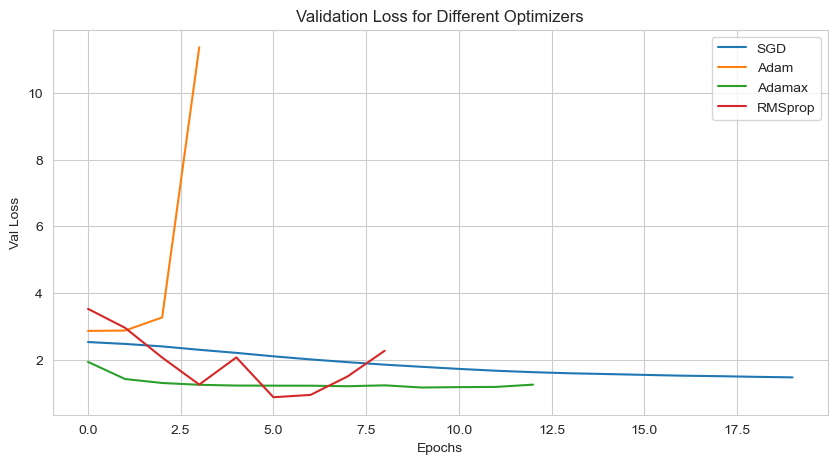

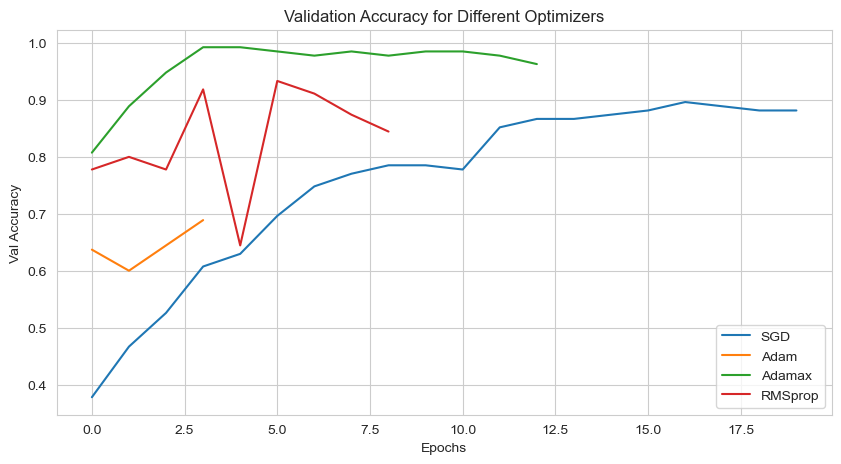

In [31]:
# Optimizer Choice experiment
optimizers = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.001),
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001),
    'Adamax': tf.keras.optimizers.Adamax(learning_rate=0.001),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001),
}
result = {}

for name, opt in optimizers.items():
    print(f"\nTraining model with optimizer: {name}")
    m = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=shape
    )

    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),

        Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(len(classes), activation='softmax')
    ])

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )
    result[name] = history

plt.figure(figsize=(10,5))
for name, history in result.items():
    plt.plot(history.history['val_loss'], label=f'{name}')
plt.title('Validation Loss for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
max_len = max([len(h.history['val_accuracy']) for h in result.values()])
for name, history in result.items():
    val_acc = history.history['val_accuracy']
    padded = val_acc + [None] * (max_len - len(val_acc))
    plt.plot(range(len(padded)), padded, label=name)
plt.title('Validation Accuracy for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.legend()
plt.show()


Training with activation function: relu
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.3041 - auc: 0.5553 - loss: 3.0237 - precision: 0.3396 - recall: 0.2301 - val_accuracy: 0.4000 - val_auc: 0.6882 - val_loss: 2.4138 - val_precision: 0.8571 - val_recall: 0.0889
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5165 - auc: 0.7664 - loss: 2.4032 - precision: 0.5860 - recall: 0.4255 - val_accuracy: 0.5852 - val_auc: 0.7857 - val_loss: 2.3036 - val_precision: 0.8400 - val_recall: 0.1556
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.6144 - auc: 0.8364 - loss: 2.1700 - precision: 0.6623 - recall: 0.5308 - val_accuracy: 0.6444 - val_auc: 0.8451 - val_loss: 2.1940 - val_precision: 0.8649 - val_recall: 0.2370
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6711 - auc: 0.8906 - loss: 1.9681 - precision: 0.7245 - recall: 0.6007 - val_accuracy: 0.7333 - val_auc: 0.8886 - val_loss: 2.0740 - val_precision: 0.9000 - val_recall: 0.3333

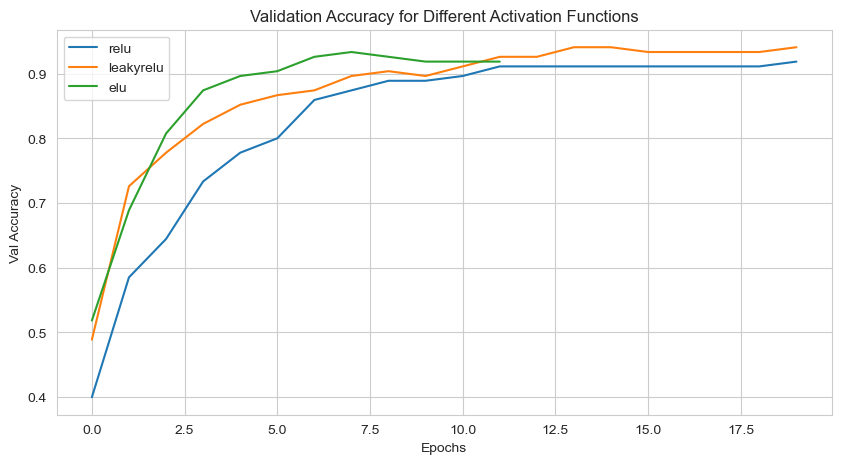

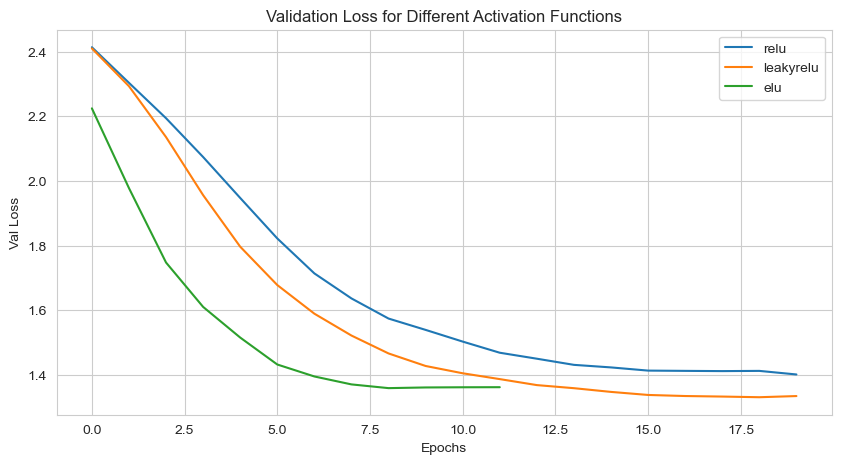

In [33]:
# Activation Function Choice experiment
from tensorflow.keras.layers import Activation, LeakyReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

def build_model_act(act_type='relu'):
    m = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=shape
    )

    def activation():
        if type == 'leakyrelu':
            return LeakyReLU(alpha=0.1)
        elif type == 'elu':
            return ELU()
        else:
            return Activation('relu')

    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),

        Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        activation(),
        Dropout(0.5),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        activation(),
        Dropout(0.3),

        Dense(len(classes), activation='softmax')
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

result = {}
for act in ['relu', 'leakyrelu', 'elu']:
    print(f'\nTraining with activation function: {act}')
    model = build_model_act(act_type=act)
    history = model.fit(train_gen, validation_data=valid_gen, epochs=20, callbacks=[es])
    result[act] = history

plt.figure(figsize=(10,5))
for act, history in result.items():
    plt.plot(history.history['val_accuracy'], label=act)
plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
for act, history in result.items():
    plt.plot(history.history['val_loss'], label=act)
plt.title('Validation Loss for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')
plt.legend()
plt.show()


🚀 Training with Dropout: D1=0.5, D2=0.3
Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.5849 - auc: 0.8026 - loss: 2.3960 - precision: 0.6033 - recall: 0.5281 - val_accuracy: 0.7778 - val_auc: 0.9331 - val_loss: 1.8975 - val_precision: 0.8031 - val_recall: 0.7556
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9403 - auc: 0.9920 - loss: 1.3449 - precision: 0.9418 - recall: 0.9403 - val_accuracy: 0.7704 - val_auc: 0.9325 - val_loss: 1.9648 - val_precision: 0.7984 - val_recall: 0.7630
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 473s 17s/step - accuracy: 0.9734 - auc: 0.9967 - loss: 1.2439 - precision: 0.9741 - recall: 0.9684 - val_accuracy: 0.9111 - val_auc: 0.9757 - val_loss: 1.4590 - val_precision: 0.9179 - val_recall: 0.9111
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9749 - auc: 0.9956 - loss: 1.2417 - precision: 0.9749 - recall: 0.9730 - val_accuracy: 0.9407 - val_auc: 0.9910 - val_loss: 1.3355 - val_precision: 0.9403 - val_recall: 0.9

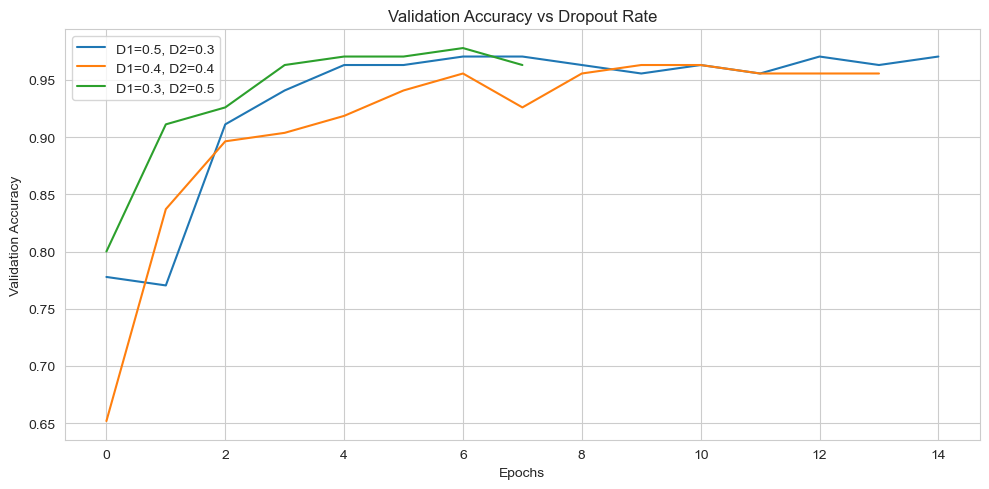

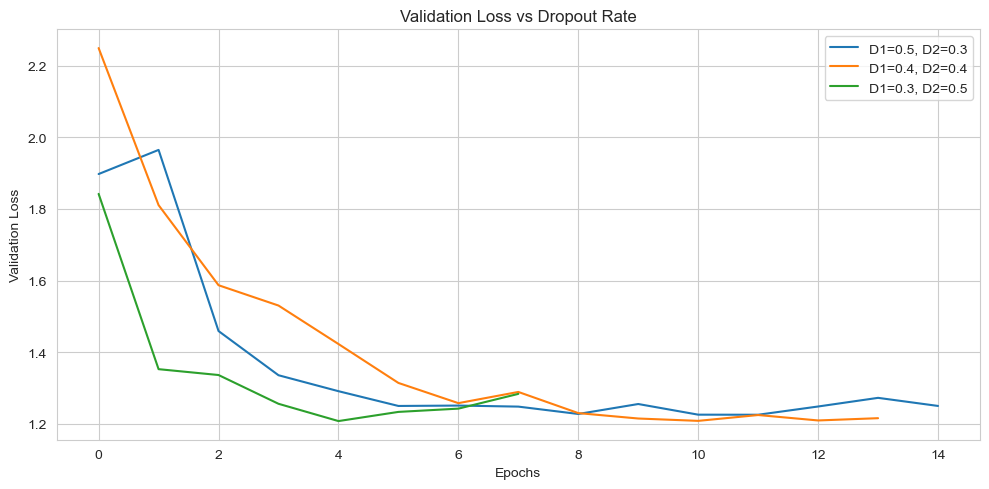


📊 Best Validation Accuracy for each Dropout setting:
D1=0.5, D2=0.3 -> Best Val Accuracy: 0.9704
D1=0.4, D2=0.4 -> Best Val Accuracy: 0.9630
D1=0.3, D2=0.5 -> Best Val Accuracy: 0.9778


In [35]:
# Dropout Rate experiment
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def build_model(dropout1=0.5, dropout2=0.3):
    m = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=shape
    )

    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),

        Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(dropout1),

        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(dropout2),

        Dense(len(classes), activation='softmax')
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    return model

dropout_coms = [
    (0.5, 0.3),
    (0.4, 0.4),
    (0.3, 0.5)
]

re = {}

for d1, d2 in dropout_coms:
    label = f"D1={d1}, D2={d2}"
    print(f" Training with Dropout: {label}")

    model = build_model(dropout1=d1, dropout2=d2)

    es = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=20,
        callbacks=[es]
    )

    re[label] = history

plt.figure(figsize=(10, 5))
for label, history in re.items():
    plt.plot(history.history['val_accuracy'], label=label)
plt.title('Validation Accuracy vs Dropout Rate')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for label, history in re.items():
    plt.plot(history.history['val_loss'], label=label)
plt.title('Validation Loss vs Dropout Rate')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Best Validation Accuracy for each Dropout setting:")
for label, history in re.items():
    best_acc = max(history.history['val_accuracy'])
    print(f"{label} -> Best Val Accuracy: {best_acc:.4f}")


Training model with L1 regularization...
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.7073 - loss: 24.9732 - val_accuracy: 0.7037 - val_loss: 20.3691
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.8875 - loss: 18.5859 - val_accuracy: 0.7852 - val_loss: 15.1098
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 0.8939 - loss: 13.7699 - val_accuracy: 0.8222 - val_loss: 10.9933
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.9455 - loss: 9.8279 - val_accuracy: 0.8741 - val_loss: 7.7575
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 419ms/step - accuracy: 0.9352 - loss: 7.0349 - val_accuracy: 0.8593 - val_loss: 5.8354
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.9366 - loss: 5.2132 - val_accuracy: 0.8593 - val_loss: 4.6046
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 417ms/step - accuracy: 0.9148 - loss: 4.4168 - val_accuracy: 0.8593 - val_loss: 4.3042
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 433ms/s

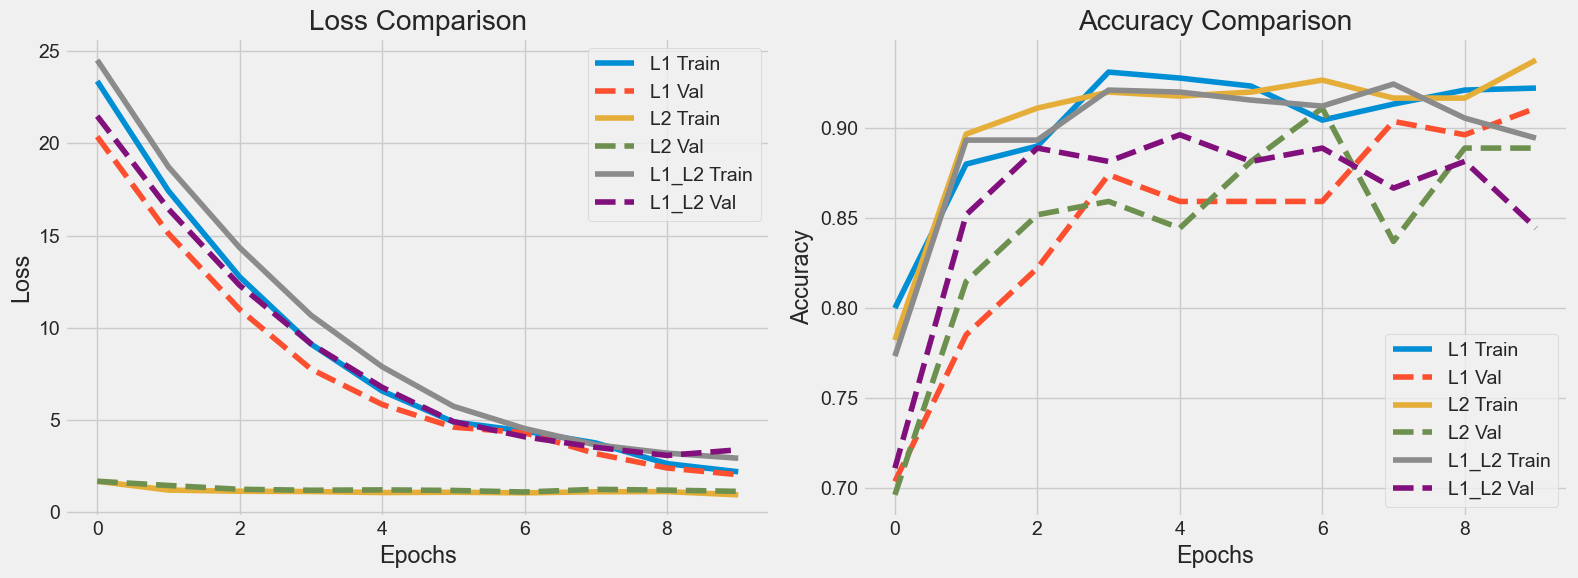

In [65]:
# L1 and L2 Regularization Parameters experiment
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

shape = (150, 150, 3)
num_classes = 4

def create_model(reg):
    m = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=shape)
    m.trainable = False
    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, kernel_regularizer=reg),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rates = {
    "L1": regularizers.l1(0.001),
    "L2": regularizers.l2(0.001),
    "L1_L2": regularizers.l1_l2(l1=0.001, l2=0.001)
}
histories = {}
for name, reg in rates.items():
    print(f"\nTraining model with {name} regularization...")
    model = create_model(reg)
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=10,
        verbose=1
    )
    histories[name] = history

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



Training with batch size: 16
Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.

Training with batch size: 32
Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.

Training with batch size: 64
Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.


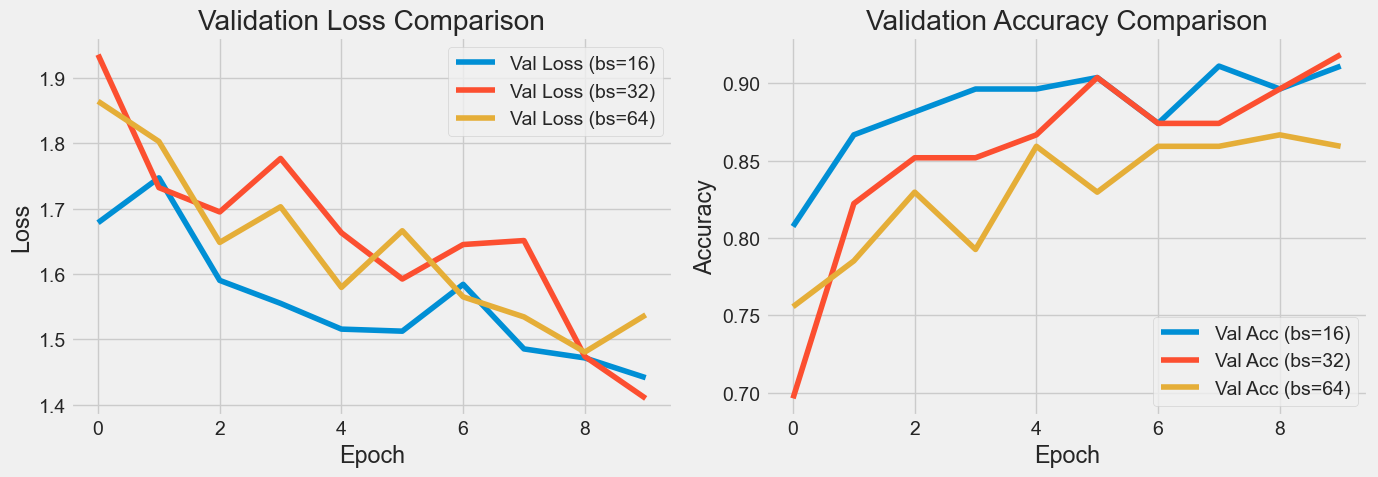

In [74]:
# Batch Size experiment
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

result = {}
batch_sizes = [16, 32, 64]

for b_s in batch_sizes:
    print(f"\nTraining with batch size: {b_s}")

    train_gen = train_gen1.flow_from_dataframe(
        dataframe=train_set,
        x_col='fp',
        y_col='labels',
        target_size=img_size,
        batch_size=b_s,
        class_mode='categorical',
        shuffle=True
    )

    valid_gen = test_datagen.flow_from_dataframe(
        dataframe=valid_set,
        x_col='fp',
        y_col='labels',
        target_size=img_size,
        batch_size=b_s,
        class_mode='categorical',
        shuffle=False
    )

    m = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )
    m.trainable = False

    model = Sequential([
        m,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(256, kernel_regularizer=regularizers.l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=10,
        callbacks=[early_stop],
        verbose=0
    )

    result[b_s] = history

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for bs in batch_sizes:
    plt.plot(result[bs].history['val_loss'], label=f'Val Loss (bs={bs})')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    plt.plot(result[bs].history['val_accuracy'], label=f'Val Acc (bs={bs})')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### **Display model performance**

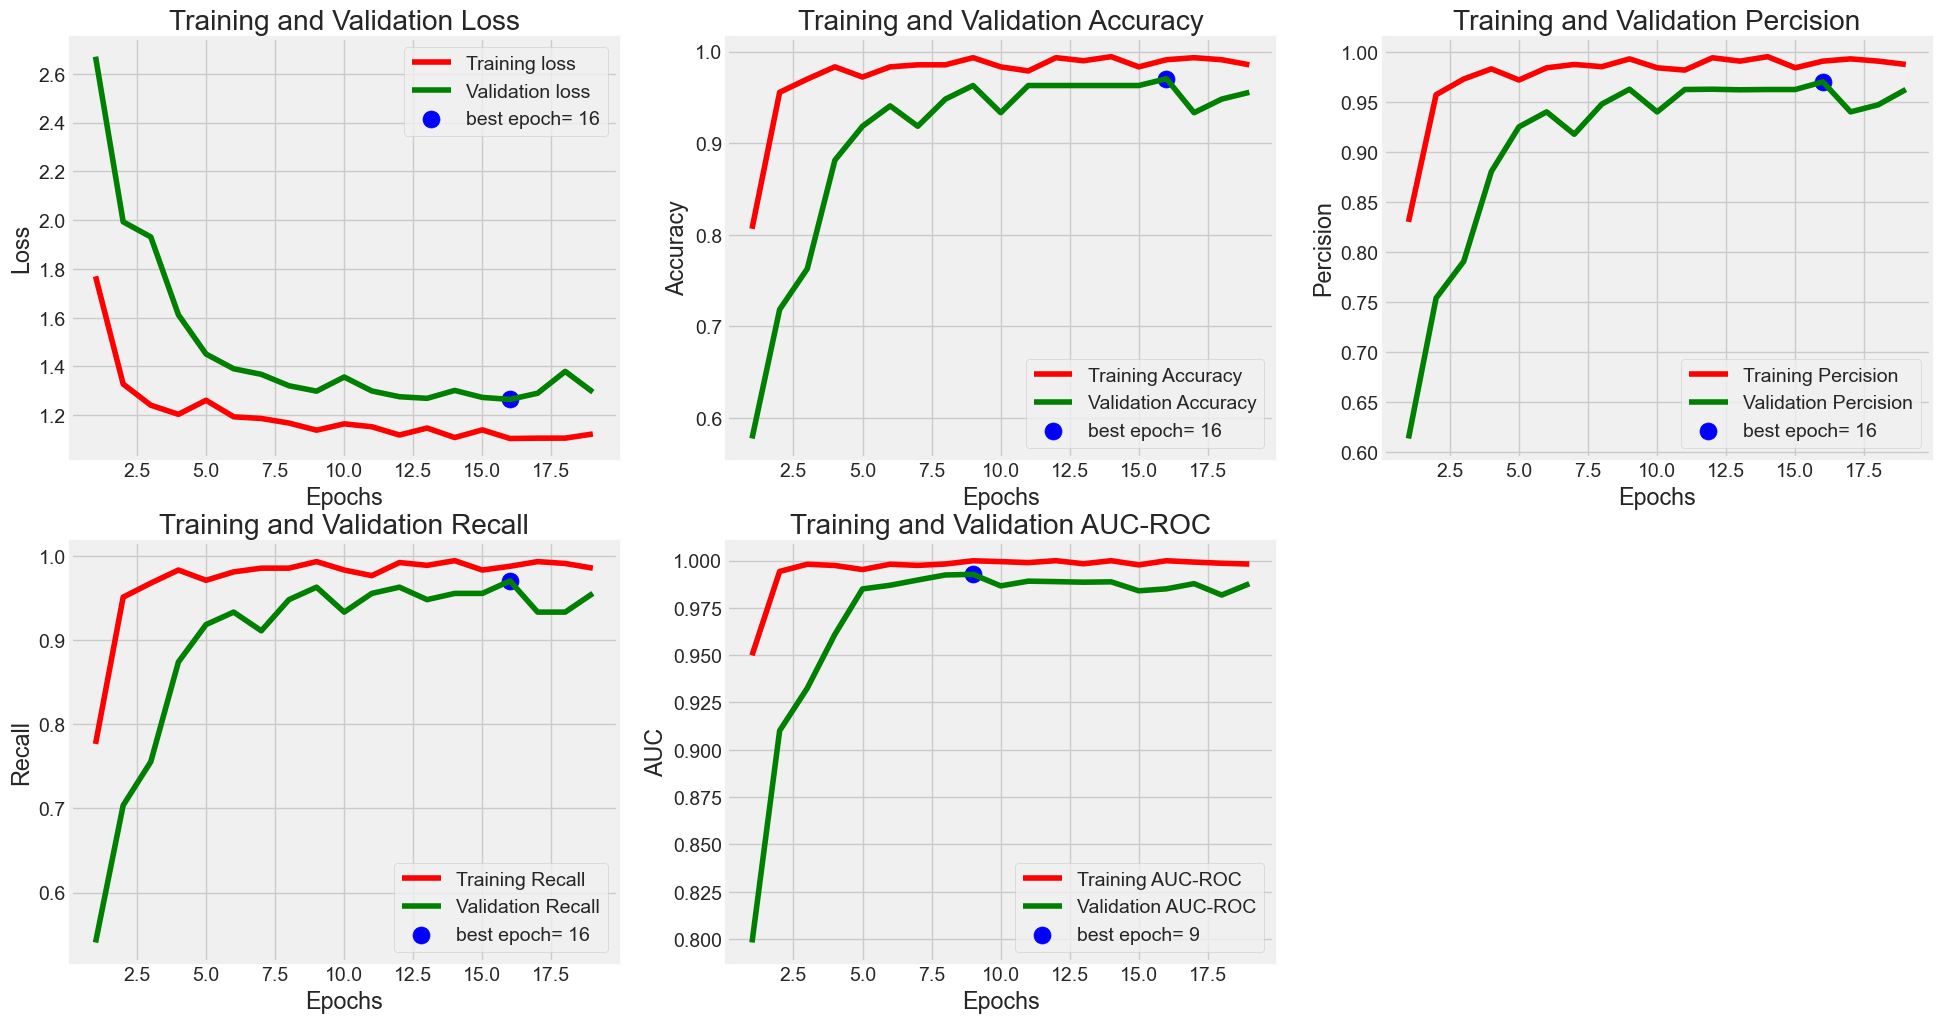

In [44]:
tr_acc = best_model_history.history['accuracy']
tr_loss = best_model_history.history['loss']
tr_perc = best_model_history.history['precision']
tr_recall = best_model_history.history['recall']
tr_auc = best_model_history.history['auc']

val_acc = best_model_history.history['val_accuracy']
val_loss = best_model_history.history['val_loss']
val_perc = best_model_history.history['val_precision']
val_recall = best_model_history.history['val_recall']
val_auc = best_model_history.history['val_auc']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_perc = np.argmax(val_perc)
perc_highest = val_perc[index_perc]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]
index_auc = np.argmax(val_auc)
auc_highest = val_auc[index_auc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
perc_label = f'best epoch= {str(index_perc + 1)}'
recall_label = f'best epoch= {str(index_recall + 1)}'
auc_label = f'best epoch= {str(index_auc + 1)}'

plt.figure(figsize=(24, 12))
plt.style.use('fivethirtyeight')
plt.subplot(2, 3, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(Epochs, tr_perc, 'r', label='Training Percision')
plt.plot(Epochs, val_perc, 'g', label='Validation Percision')
plt.scatter(index_perc + 1, perc_highest, s=150, c='blue', label=perc_label)
plt.title('Training and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Percision')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(Epochs, tr_auc, 'r', label='Training AUC-ROC')
plt.plot(Epochs, val_auc, 'g', label='Validation AUC-ROC')
plt.scatter(index_auc + 1, auc_highest, s=150, c='blue', label=auc_label)
plt.title('Training and Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

<Figure size 640x480 with 0 Axes>

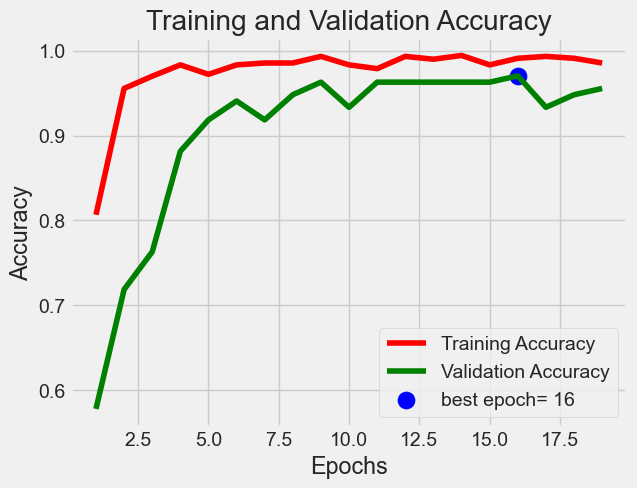

In [46]:
plt.tight_layout()
plt.show()
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# **Evaluate model**

In [49]:
test_len = len(test_set)
test_batch_size = max(
    sorted([test_len // n for n in range(1, test_len + 1) if test_len % n == 0 and test_len / n <= 80]))
steps = test_len // test_batch_size

train_score = model.evaluate(train_gen, steps=steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=steps, verbose=1)
test_score = model.evaluate(test_gen, steps=steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 1.0802 - precision: 1.0000 - recall: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.9583 - auc: 0.9843 - loss: 1.2735 - precision: 0.9583 - recall: 0.9583
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step - accuracy: 0.9583 - auc: 0.9993 - loss: 1.1553 - precision: 0.9583 - recall: 0.9583
Train Loss:  1.0803760290145874
Train Accuracy:  1.0
--------------------
Validation Loss:  1.2259217500686646
Validation Accuracy:  0.96875
--------------------
Test Loss:  1.1714118719100952
Test Accuracy:  0.953125


# **Get Predictions**

In [52]:
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step


#### **Confusion Matrics**

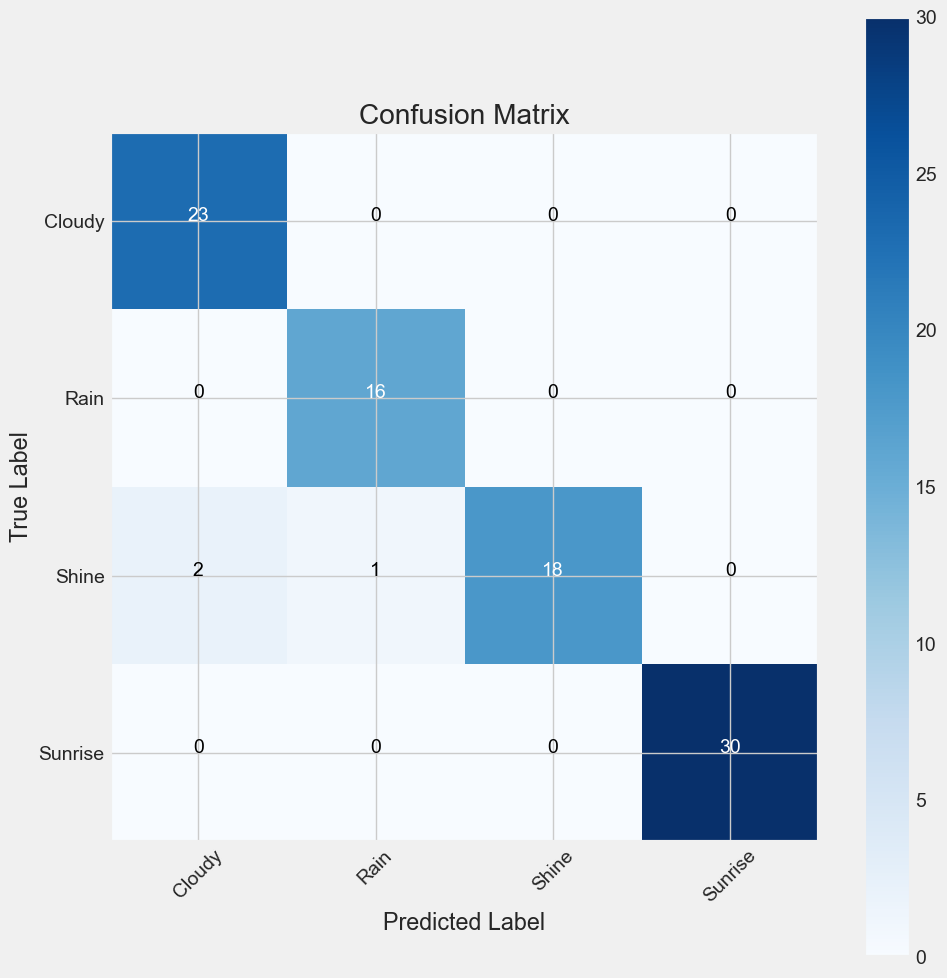

In [55]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tm = np.arange(len(classes))
plt.xticks(tm, classes, rotation=45)
plt.yticks(tm, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### **Classification Report**

In [57]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Cloudy       0.92      1.00      0.96        23
        Rain       0.94      1.00      0.97        16
       Shine       1.00      0.86      0.92        21
     Sunrise       1.00      1.00      1.00        30

    accuracy                           0.97        90
   macro avg       0.97      0.96      0.96        90
weighted avg       0.97      0.97      0.97        90



### **Visualize Misclassified Test Images**


Misclassified Samples: 3


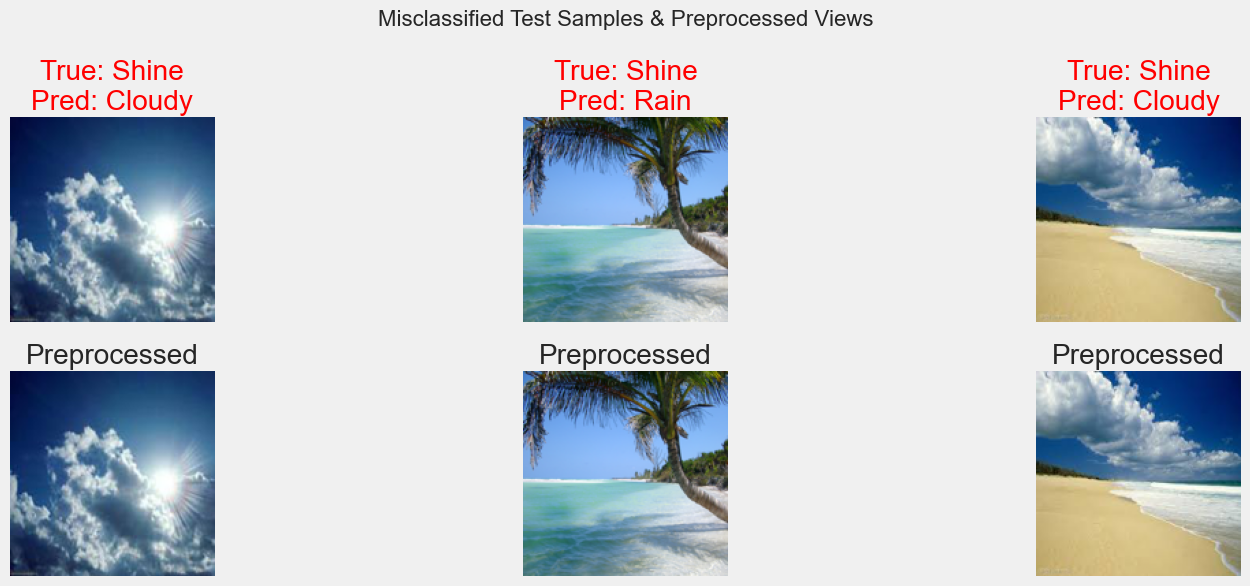

In [60]:
y_true = test_gen.classes
fp = test_set["fp"].values
inv_class_indices = {v: k for k, v in test_gen.class_indices.items()}
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Misclassified Samples: {len(misclassified_indices)}")

sampled = random.sample(list(misclassified_indices), min(8, len(misclassified_indices)))
plt.figure(figsize=(18, 6))

for i, idx in enumerate(sampled):
    img_path = fp[idx]
    raw_img = Image.open(img_path).resize(img_size)
    plt.subplot(2, len(sampled), i + 1)
    plt.imshow(raw_img)
    plt.title(f"True: {inv_class_indices[y_true[idx]]}\nPred: {inv_class_indices[y_pred[idx]]}", color="red")
    plt.axis("off")
    plt.subplot(2, len(sampled), len(sampled) + i + 1)
    preprocessed_img = np.array(raw_img) / 255.0
    plt.imshow(preprocessed_img)
    plt.title("Preprocessed")
    plt.axis("off")

plt.suptitle("Misclassified Test Samples & Preprocessed Views", fontsize=16)
plt.tight_layout()
plt.show()

#### **Save model**

In [ ]:
model.save('ًWeather Model.h5')